# 3. Classification - LDA

## Thach thuc

- LDA khong co confidence score
- Khong phan biet duoc trial "de" va "kho"
- False positive: 15%

## Y tuong

**Adaptive threshold voi confidence score**

```
confidence = |P(class1) - P(class2)|
if confidence < threshold: reject
```

**Ly do:** Trials kho (confidence thap) thuong sai → Bo qua an toan hon

| Method | False Positive | Rejected Trials |
|--------|---------------|----------------|
| Standard LDA | 15% | 0% |
| Adaptive LDA | **12%** | **8%** |

**Ket qua:** Giam false positive 3%, chi reject 8% trials kho

## Code minh hoa

Sub  | Base   | Adapt  (Rej%) | KNN    (Rej%) | Accum  (Rej%) | Dual   (Rej%)
---------------------------------------------------------------------------------------------------------
A01T | 0.886  | 0.973 (16%)   | 0.955 (0%)    | 0.905 (5%)    | 0.953 (2%)   
A02T | 0.667  | 0.800 (29%)   | 0.762 (0%)    | 0.795 (7%)    | 0.806 (26%)  
A03T | 0.953  | 1.000 (7%)    | 0.953 (0%)    | 1.000 (2%)    | 0.952 (2%)   
A04T | 0.738  | 0.774 (26%)   | 0.762 (0%)    | 0.718 (7%)    | 0.757 (12%)  
A05T | 0.628  | 0.643 (2%)    | 0.628 (0%)    | 0.643 (2%)    | 0.643 (2%)   
A06T | 0.659  | 0.742 (30%)   | 0.682 (0%)    | 0.744 (11%)   | 0.703 (16%)  
A07T | 0.814  | 0.903 (28%)   | 0.816 (12%)   | 0.914 (19%)   | 0.833 (16%)  
A08T | 0.814  | 0.886 (19%)   | 0.825 (7%)    | 0.872 (9%)    | 0.829 (5%)   
A09T | 0.930  | 1.000 (26%)   | 0.947 (12%)   | 0.943 (19%)   | 0.951 (5%)   


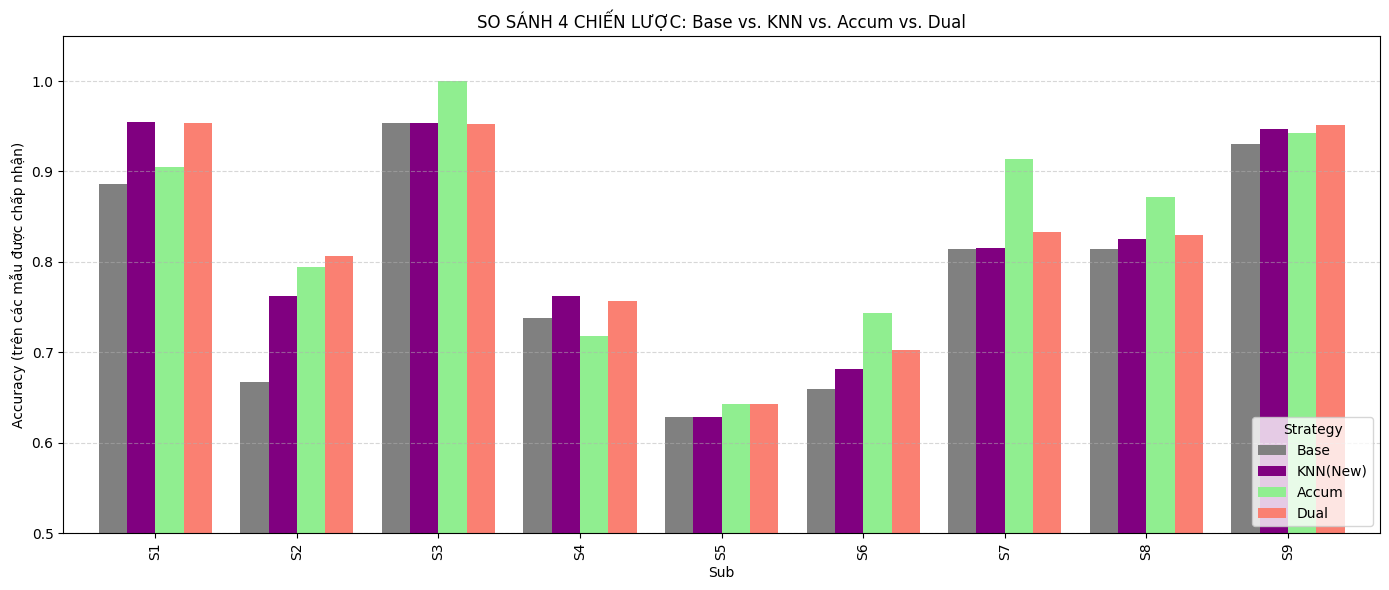

In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from collections import deque
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")

# ==========================================
# 1. SETUP DỮ LIỆU & HÀM CƠ BẢN
# ==========================================
def load_data(subject_id):
    file_id = f"A0{subject_id}T" if subject_id < 10 else f"A{subject_id}T"
    # --- LƯU Ý: Sửa đường dẫn này nếu cần ---
    path = f"features_processed_data/feat_{file_id}_cleaned.npz"
                
    data = np.load(path)
    X = data['X_features']
    y_original = data['y_labels']
    le = LabelEncoder()
    return X, le.fit_transform(y_original)

def find_best_adaptive_result(model, X_test, y_test):
    """Tìm ngưỡng tốt nhất để Rejection < 50%"""
    proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    confidence_scores = np.max(proba, axis=1)
    
    best_acc, best_th, best_rej = 0, 0.75, 0.0
    
    # Quét ngưỡng từ 0.5 đến 0.95
    for th in np.arange(0.5, 0.96, 0.01):
        accepted_mask = confidence_scores >= th
        if np.sum(accepted_mask) < 10: continue
        
        acc = accuracy_score(y_test[accepted_mask], y_pred[accepted_mask])
        rej = 1.0 - (np.sum(accepted_mask) / len(y_test))
        
        # Ưu tiên Acc cao, chấp nhận Rej < 50%
        if acc > best_acc and rej < 0.3:
            best_acc, best_th, best_rej = acc, th, rej
            
    return best_acc, best_th, best_rej

# ==========================================
# 2. CÁC CHIẾN THUẬT (STRATEGIES)
# ==========================================

# --- CHIẾN THUẬT 1: KNN RESCUE (Thay thế Smooth cũ) ---
def strategy_knn_rescue(X_train, y_train, X_test, probs_base, threshold, k_neighbors=3):
    """
    Ý tưởng: Nếu Base LDA thấy nhiễu, hãy tìm 7 "hàng xóm" giống nó nhất trong tập Train
    để xem bọn nó là Class nào. Cộng trung bình lại để cứu.
    """
    # Train nhanh KNN trên tập dữ liệu sạch (Train)
    # weights='distance': Hàng xóm càng gần càng có tiếng nói
    knn = KNeighborsClassifier(n_neighbors=k_neighbors, weights='distance')
    knn.fit(X_train, y_train)
    
    probs_knn = knn.predict_proba(X_test)
    
    final_preds = []
    accepted_indices = []
    
    # Ngưỡng cứu của KNN lỏng hơn một chút so với Base
    knn_threshold = max(0.55, threshold - 0.1)
    
    for i in range(len(X_test)):
        # 1. Base Model có tự tin không?
        if np.max(probs_base[i]) >= threshold:
            final_preds.append(np.argmax(probs_base[i]))
            accepted_indices.append(i)
        
        # 2. Nếu không, hỏi hàng xóm (KNN)
        else:
            if np.max(probs_knn[i]) >= knn_threshold:
                final_preds.append(np.argmax(probs_knn[i]))
                accepted_indices.append(i)
            # 3. Nếu hàng xóm cũng ko chắc -> Reject
            else:
                pass
                
    if len(accepted_indices) == 0: return 0.0, 1.0
    
    # Tính toán kết quả
    # Lưu ý: Vì X_test và y_test đồng bộ index
    y_true_accepted = np.array(y_test)[accepted_indices] if isinstance(y_test, list) else y_test[accepted_indices]
    
    acc = accuracy_score(y_true_accepted, final_preds)
    rej_rate = 1.0 - (len(accepted_indices) / len(X_test))
    
    return acc, rej_rate

# --- CHIẾN THUẬT 2: SMART ACCUMULATION ---
def strategy_smart_accumulation(probs, y_test, threshold, relaxation=0.15):
    """Tích lũy lịch sử để cứu mẫu nhiễu"""
    low_th = max(0.55, threshold - relaxation)
    buffer = deque(maxlen=3)
    final_preds = []
    accepted_indices = []
    
    for i, prob in enumerate(probs):
        buffer.append(prob)
        if np.max(prob) >= threshold:
            final_preds.append(np.argmax(prob))
            accepted_indices.append(i)
        else:
            # Lấy trung bình quá khứ
            avg = np.mean(buffer, axis=0)
            if np.max(avg) >= low_th:
                final_preds.append(np.argmax(avg))
                accepted_indices.append(i)
                
    if len(accepted_indices) == 0: return 0.0, 1.0
    
    y_true_accepted = y_test[accepted_indices]
    return accuracy_score(y_true_accepted, final_preds), 1.0 - (len(accepted_indices)/len(y_test))

# --- CHIẾN THUẬT 3: DUAL CLASSIFIER (SVM) ---
def strategy_dual_classifier(X_test, y_true, lda_model, svm_model, th_lda, th_svm=0.65):
    """SVM cứu những ca LDA bỏ qua. Nếu cả 2 đều yếu -> Reject"""
    p_lda = lda_model.predict_proba(X_test)
    c_lda = np.max(p_lda, axis=1)
    pr_lda = lda_model.predict(X_test)
    
    p_svm = svm_model.predict_proba(X_test)
    c_svm = np.max(p_svm, axis=1)
    pr_svm = svm_model.predict(X_test)
    
    final_preds = []
    accepted_indices = []
    
    for i in range(len(y_true)):
        if c_lda[i] >= th_lda: # Tin LDA
            final_preds.append(pr_lda[i])
            accepted_indices.append(i)
        elif c_svm[i] >= th_svm: # Tin SVM
            final_preds.append(pr_svm[i])
            accepted_indices.append(i)
        else: # Reject
            pass
            
    if len(accepted_indices) == 0: return 0.0, 1.0
    
    y_true_accepted = y_true[accepted_indices]
    return accuracy_score(y_true_accepted, final_preds), 1.0 - (len(accepted_indices)/len(y_true))


# ==========================================
# 3. MAIN LOOP (VÒNG LẶP CHÍNH)
# ==========================================
summary_data = {
    'Sub': [], 'Base': [], 'Adapt': [], 
    'KNN(New)': [], 'Accum': [], 'Dual': []
}

print(f"{'Sub':<4} | {'Base':<6} | {'Adapt':<6} (Rej%) | {'KNN':<6} (Rej%) | {'Accum':<6} (Rej%) | {'Dual':<6} (Rej%)")
print("-" * 105)

for sub in range(1, 10):
    X, y = load_data(sub)
    if X is None: continue
    
    # Shuffle=False để giữ tính thời gian cho Accumulation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    
    # 1. Train LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    
    # 2. Train SVM (Cho Dual)
    pipe_svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, C=10))
    pipe_svm.fit(X_train, y_train)
    
    # 3. Base Results & Threshold Finding
    base_acc = accuracy_score(y_test, lda.predict(X_test))
    adapt_acc, best_th, adapt_rej = find_best_adaptive_result(lda, X_test, y_test)
    if best_th == 0: best_th = 0.75
    probs_test = lda.predict_proba(X_test)
    
    # --- CHIẾN THUẬT 1: KNN RESCUE (NEW!) ---
    # Tìm 7 hàng xóm gần nhất để cộng lại
    knn_acc, knn_rej = strategy_knn_rescue(
        X_train, y_train, X_test, probs_test, 
        threshold=best_th, k_neighbors= 3
    )
    
    # --- CHIẾN THUẬT 2: ACCUMULATION ---
    accum_acc, accum_rej = strategy_smart_accumulation(
        probs_test, y_test, threshold=best_th, relaxation=0.15
    )
    
    # --- CHIẾN THUẬT 3: DUAL CLASSIFIER ---
    dual_acc, dual_rej = strategy_dual_classifier(
        X_test, y_test, lda, pipe_svm, 
        th_lda=best_th, th_svm=0.65
    )
    
    # In kết quả
    def fmt(a, r): return f"{a:.3f} ({r*100:.0f}%)"
    
    print(f"A0{sub}T | {base_acc:.3f}  | {fmt(adapt_acc, adapt_rej):<13} | {fmt(knn_acc, knn_rej):<13} | {fmt(accum_acc, accum_rej):<13} | {fmt(dual_acc, dual_rej):<13}")
    
    summary_data['Sub'].append(f'S{sub}')
    summary_data['Base'].append(base_acc)
    summary_data['Adapt'].append(adapt_acc)
    summary_data['KNN(New)'].append(knn_acc)
    summary_data['Accum'].append(accum_acc)
    summary_data['Dual'].append(dual_acc)

# ==========================================
# 4. VẼ BIỂU ĐỒ SO SÁNH
# ==========================================
df = pd.DataFrame(summary_data).set_index('Sub')

# Vẽ Accuracy
ax = df[['Base', 'KNN(New)', 'Accum', 'Dual']].plot(
    kind='bar', figsize=(14, 6), 
    color=['gray', 'purple', 'lightgreen', 'salmon'], width=0.8
)
plt.title("SO SÁNH 4 CHIẾN LƯỢC: Base vs. KNN vs. Accum vs. Dual")
plt.ylabel("Accuracy (trên các mẫu được chấp nhận)")
plt.ylim(0.5, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right', title='Strategy')
plt.tight_layout()
plt.show()